## Importar Librerias Estandar

In [1]:
import pandas as pd
import json
import datetime as dt
import numpy as np
import re
import warnings as w
w.filterwarnings('ignore')

In [3]:
### variable con volores enteros
## id_observacion, gasto*, fecha_captura_informacion*, fuente*, nombre_campania*, impresiones* no presentan valores nulos
## cuando el arte no se publica (id_anuncio*, id_conjunto_anuncios*, id_campania*) al 42%, fecha_publicacion_anuncio*, formato* presentan valores nulos
## objetivo_campania* presenta valores nulos al 24%, tomando en cuenta las artes que no se publicaron presenta valores nulos al 57%
## visitas_al_50*, visitas_al_75*, visitas_al100* presentan valores nulos al 18%, tomando en cuenta las artes que no se publicaron presenta valores nulos al 48%

## Definir Funciones

In [2]:
def get_train():
    #method: cargar la data de entrenamiento
    with open('../data/train.json', mode='r') as f:
        data = json.load(f)
    list_dict_data = []
    for i in data:
        dict_data = {}
        for j in i:
            dict_data[list(j.keys())[0]] = j[list(j.keys())[0]]
        list_dict_data.append(dict_data)
    df = pd.DataFrame(list_dict_data)
    return df

def get_normalize_columns(df):
    ##method: normalizar los nombres de columnas
    df.columns = [i.strip().lower().translate(str.maketrans('áéíóúü','aeiouu')) for i in df.columns]
    return df

def get_feature_engineering(df):
    ##method: aplicar feature engineering
    df.replace({None:np.nan}, inplace=True)    
    df.sort_values(['id_anuncio','fecha_captura_informacion'], ascending = True, inplace = True)
    df['nombre_campania'] = df['nombre_campania'].replace({'GASTRONOMIA':'GASTRONOMY','GASTRONOMÃ�A':'GASTRONOMY','GASTRONOMÍA':'GASTRONOMY'})
    df['fecha_publicacion_anuncio'] = df['fecha_publicacion_anuncio'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if str(x)!='nan' else np.nan)
    df['fecha_captura_informacion'] = df['fecha_captura_informacion'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if str(x)!='nan' else np.nan)
    df['duracion_anuncio_dias'] = (df['fecha_captura_informacion'] - df['fecha_publicacion_anuncio']).dt.days
    df['fecha_captura_informacion_day'] = df['fecha_captura_informacion'].apply(lambda x: x.day)
    df['fecha_captura_informacion_month'] = df['fecha_captura_informacion'].apply(lambda x: x.month)
    df['fecha_publicacion_anuncio_day'] = df['fecha_publicacion_anuncio'].apply(lambda x: x.day)
    df['fecha_publicacion_anuncio_month'] = df['fecha_publicacion_anuncio'].apply(lambda x: x.month)    
    grouped = df.groupby('id_anuncio')
    diff = lambda x: x['fecha_captura_informacion'].replace(0, np.NaN).diff() 
    df["diff_captura_anterior"] = grouped.apply(diff).reset_index(0, drop = True).dt.days
    df['diff_captura_anterior'].fillna(df['duracion_anuncio_dias'], inplace = True)
    return df

def get_normalize_values(x):
    ##method: normalizar los valores de las variables categoricas
    x = x.lower()
    x = x.strip()
    x = re.sub(r'\s+',' ', x)
    x = x.translate(str.maketrans('áéíóúü','aeiouu'))
    return x

def get_one_hot(df, feature):
    ##method: aplicar one_hot_enconding a las variables categoricas
    df[feature] = df[feature].apply(lambda x:get_normalize_values(x) if type(x)==str else np.nan)
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+ i for i in one_hot.columns]
    return one_hot

def get_feature_selection(fi):
    ##method: encontar las variables con una importancia acumulativa al 99% y las variables con zero importancia
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

## Cargar Train y Test 

In [4]:
train = get_train()
test = pd.read_csv('../data/Data_Validacion.csv',sep=';')

## Procesamiento de la data (Train, Test, Target)

In [5]:
var_categ = ['fuente','objetivo_campania','formato','nombre_campania']
train = get_normalize_columns(train)
test = get_normalize_columns(test)
train = get_feature_engineering(train)
test = get_feature_engineering(test)

list_one_hot_train = []
for i in var_categ:
    df = get_one_hot(train, i)
    list_one_hot_train.append(df)
one_hot_train = pd.concat(list_one_hot_train,axis=1)
train = train.join(one_hot_train)

train.set_index('id_observacion', inplace=True)
y_train = train[['interacciones']].rename(columns = {'interacciones':'target'})
train.drop(var_categ +\
           ['id_conjunto_anuncios', 'id_anuncio', 'id_campania',\
            'moneda', 'country', 'brand','fecha_publicacion_anuncio','fecha_captura_informacion'], axis=1, inplace=True)

list_one_hot_test = []
for i in var_categ:
    df = get_one_hot(test, i)
    list_one_hot_test.append(df)
one_hot_test = pd.concat(list_one_hot_test,axis=1)    
test = test.join(one_hot_test)
test.set_index('id_observacion', inplace=True)
test.drop(var_categ +\
           ['id_conjunto_anuncios', 'id_anuncio', 'id_campania',\
            'moneda', 'country', 'brand','fecha_publicacion_anuncio','fecha_captura_informacion'], axis=1, inplace=True)
test['gasto'] = test['gasto'].replace({'40000%':40000})
test['gasto'] = test['gasto'].astype(float)

## Uniformizar las variables en Train y Test

In [14]:
try:
    features_importances_rec = features_importances[features_importances>0]
    train = train[features_importances_rec.index]
    test = test[features_importances_rec.index]
    print('entrando a feature_importances', train.shape, test.shape)
except:
    keep_columns = set(test.columns).intersection(set(train.columns))
    train = train[keep_columns]
    test = test[keep_columns]
    print('normal', train.shape, test.shape)

entrando a feature_importances (5562, 39) (2378, 39)


## Cross Validation

In [15]:
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import ParameterGrid
# params = ParameterGrid({"min_child_samples": [10, 20, 25],
#                         "max_depth":[6, 9, -1], 
#                         "learning_rate":[0.1,0.2]})
# # test_probs = []
# # train_probs = []
# # fi = []
# folds = [train.index[t] for t, v in KFold(5).split(train)]
# result_tunning = {"score":999999,"param":""}
# for param in params:
#     test_probs = []
#     train_probs = []
#     for i, idx in enumerate(folds):
#         # print("*"*10, i, "*"*10)
#         Xt = train.loc[idx]
#         yt = y_train.loc[Xt.index].target

#         Xv = train.drop(Xt.index)
#         yv = y_train.loc[Xv.index].target

#         learner = LGBMRegressor(n_estimators=1000, random_state=42, **param)

#         learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
#                         eval_set=[(Xt, yt), (Xv, yv)], verbose = False)

#         test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
#         train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
#         # fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

#     test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
#     test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

#     train_probs = pd.concat(train_probs)
#     train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

#     # fi = pd.concat(fi, axis=1).mean(axis=1)
#     #print('rmse', np.sqrt(np.sum(( train_probs.loc[train.index] - y_train.loc[train.index].target)**2)/len(train)))
#     score = mean_squared_error(y_train.loc[train.index].target, train_probs.loc[train.index], squared=False)
#     print('param', param, score)
#     if score < result_tunning["score"]:
#         result_tunning["score"] = score
#         result_tunning["param"] = param
# print(result_tunning)

## Entrenamiento de la Data 

In [16]:
from lightgbm import LGBMRegressor
# learner = LGBMRegressor(n_estimators=1000,  random_state=42, **result_tunning["param"]) 
learner = LGBMRegressor(n_estimators=1000,  random_state=42)
learner.fit(train, y_train, eval_metric="rmse")

LGBMRegressor(n_estimators=1000, random_state=42)

## Visualización del la Importancia de Variables

In [17]:
features_importances = pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 39
variables con importancia acumulada al 99% : 26
variables con zero importancia : 0


In [22]:
features_importances

gasto                                0.250367
impresiones                          0.192500
fecha_captura_informacion_day        0.123800
duracion_anuncio_dias                0.090467
visitas_al_50                        0.054733
diff_captura_anterior                0.052567
fecha_publicacion_anuncio_day        0.041767
visitas_al100                        0.036867
fecha_captura_informacion_month      0.029700
visitas_al_75                        0.021767
fecha_publicacion_anuncio_month      0.014733
fuente_direct                        0.013600
objetivo_campania_traffic            0.011100
nombre_campania_gastronomy           0.009300
objetivo_campania_engagement         0.007333
fuente_fb + ig                       0.005533
objetivo_campania_video views        0.005367
objetivo_campania_brand awareness    0.005100
formato_imagen                       0.004400
formato_carrusel                     0.003767
fuente_facebook                      0.003300
fuente_twitter                    

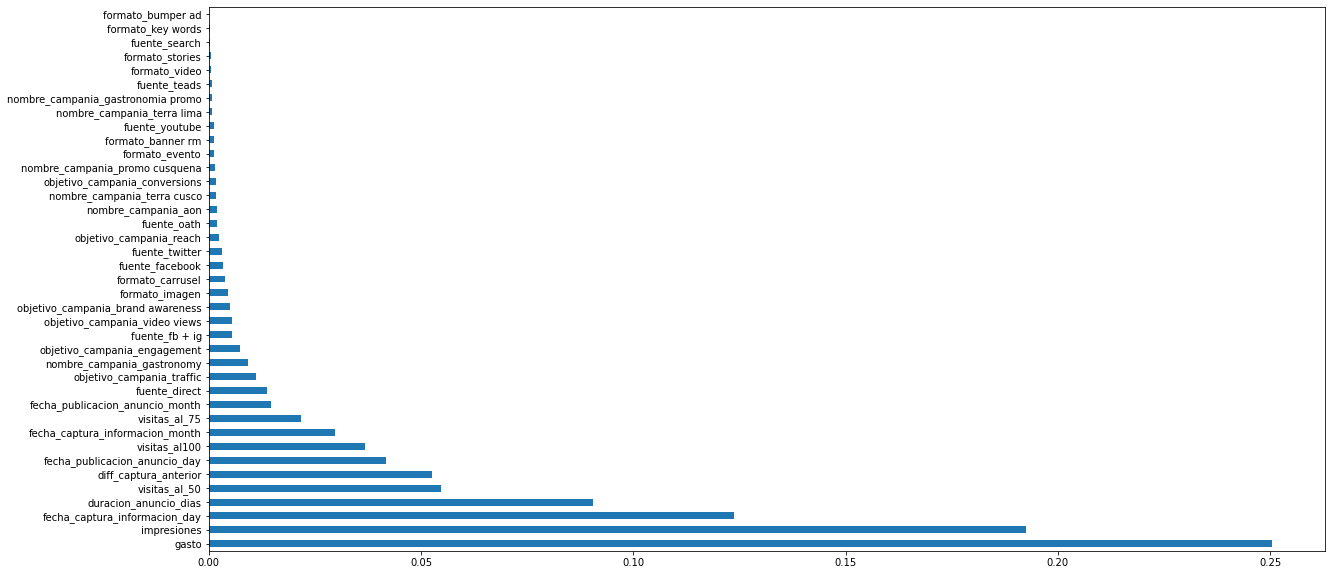

In [18]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

## Submit

In [19]:
test_submit = test.copy()
test_submit['INTERACCIONES'] = learner.predict(test_submit)
mask = test_submit['INTERACCIONES']<=0
test_submit.loc[mask,'INTERACCIONES'] = 0

In [20]:
test_submit = test_submit.reset_index()
test_submit = test_submit[['id_observacion','INTERACCIONES']]
test_submit.columns = ['ID_OBSERVACION', 'INTERACCIONES']
test_submit

,ID_OBSERVACION,INTERACCIONES
0,ID_V_001297,21.896696
1,ID_V_001317,155.334837
2,ID_V_001305,92.332752
3,ID_V_001312,0.000000
4,ID_V_001324,0.000000
...,...,...
2373,ID_V_002241,0.000000
2374,ID_V_001861,0.000000
2375,ID_V_001864,2399.018961
2376,ID_V_001865,3195.240060


In [21]:
test_submit.to_csv('../results/test_final.csv', index=False)